Assignment 1 : 20 Newsgroups Dataset Assignment: Text Classification and Clustering

 ☀️ Name : Sridhanya Ganapathi
 ☀️ Bits ID: 2022da04483

# Summary of learnings in this data set

- 💥 Machine understands only numbers and the embeddings are generated using Word2Vec, Glove or anysuch.
- 💥 pre-trained models have the benefit of not needing as much data as building a model from scratch.
- 💥 And our conclusion is BERT has significantly improve contextual understanding.
For example bank vault and river bank 'bank' are semantically different
- 💥 BERT does preprocess itself hence I used fetched dataset where as for other algorithms we use preprocess data
- 💥 Preprocessing I choose Lemmitizer rather than stemming(as it is bruteforce and introduce spelling errors)   
- 💥 Clustering Algorithm performs better than Naive Bayes because of linear distribution of data
- 💥 Regularization I attempted, Grid Search CV, CrossValidationScore 
- 💥 Imbalance issue is not present here but if present (programatically introduced) ,
SMOTE / RandomSampler
- 💥 dealing with slang, abbreviations or typos, and addressing context and word disambiguation challenges is demonstrated by samples
- 💥 Topic modeling in NLP is a set of algorithms that can be used to summarise automatically over a large corpus of texts.
- 💥 Various Visuals like WordCloud, Plotly, Scatter plot , plLDAvis etc are used
- 💥 Various  metrics like confusion matrix , classification report etc are aded to evaluvate metrics

# ✅ Text Pre-processing and Embedding Comparison
   - 🗼 Preprocessing steps correctly implemented and explained 
   - 🗼 Comparison of word2vec, GloVe, and OpenAI embeddings
   - 🗼 Discussion on the embeddings that provide better semantic understanding

# ✅ Install needed libraries

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [1]:
!pip3 install  scikit-learn
!pip3 install autocorrect
!pip3 install nltk
!pip3 install sentence-transformers
!pip3 install transformers==4.18.0
!pip3 install imblearn
!pip3 install wordcloud
!pip3 install pytorch-pretrained-bert
!pip3 install bertopic
!pip3 install pyspellchecker
!pip3 install numpy
!pip3  install wordcloud

### Supress warnings

In [3]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")


### All needed imports

In [4]:
from transformers import BertTokenizer
import nltk
import re
import nltk
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
nltk.download("punkt")
nltk.download('stopwords')
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from string import punctuation
from nltk.corpus import stopwords, brown
import re
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns


# ✅ Loading Data

In [6]:
from sklearn.datasets import fetch_20newsgroups

In [7]:
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med', 'talk.religion.misc',
            'sci.space']

In [8]:
remove = ('headers', 'footers', 'quotes')

In [9]:
def convert_to_np(dataset):
    return np.asarray(dataset.data), dataset.target

In [10]:
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

x_validation,y_validation =convert_to_np(data_test)
x_train,y_train = convert_to_np(data_train)

print('data loaded')

data loaded


In [11]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

In [12]:
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

In [13]:
print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

3227 documents - 4.110MB (training set)
2147 documents - 3.037MB (test set)
6 categories



# ✅ To understand Data distribution of data 

In [14]:
# Finding frequency of each category
targets, frequency = np.unique(data_train.target, return_counts=True)
targets, frequency 

(array([0, 1, 2, 3, 4, 5]), array([480, 584, 594, 593, 599, 377]))

In [15]:
targets_str = np.array(data_train.target_names)
print(list(zip(targets_str, frequency)))

[('alt.atheism', 480), ('comp.graphics', 584), ('sci.med', 594), ('sci.space', 593), ('soc.religion.christian', 599), ('talk.religion.misc', 377)]


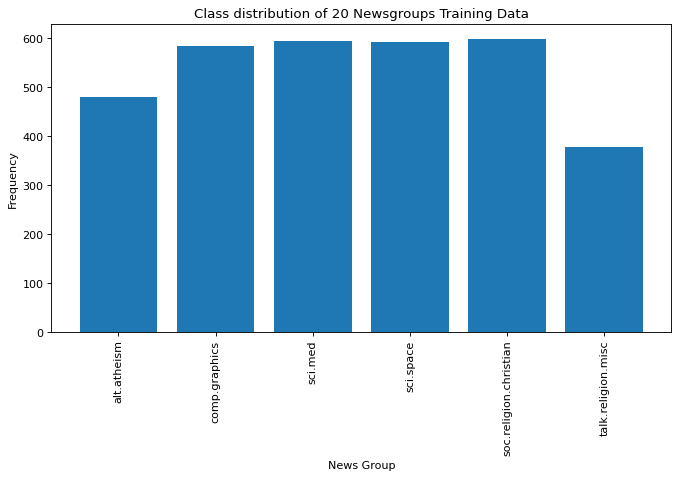

In [16]:
# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

<span style="background-color: #FFFF00">This dataset has equal samples in all categories and no imbalance issues</span>

# Preprocessing steps correctly implemented and explained 
-------------------------------------------------------
Below are the steps incorporated for preprocessing 
    Noise removal:digits, characters, and pieces of text that interfere with the process of text analysis
    Lowercasing:to deal with sparsity issues in the dataset we have done this step
    Normalization :
      1) Stop-word removal
      2) We choose Lemmatization over Stemming as it is doing  things properly with the use of vocabulary and morphological analysis of words
      3) Speller to fix speeling errors

In [17]:
# example didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't"
stop_words  = stopwords.words('english')


In [18]:
from autocorrect import Speller
from nltk.tokenize import word_tokenize


def to_lower(text):

    """
    Converting text to lower case as in, converting "Hello" to  "hello" or "HELLO" to "hello".
    """
    
    # Specll check the words
    spell  = Speller(lang='en')
    
    texts = spell(text)
    
    return ' '.join([w.lower() for w in word_tokenize(text)])

In [19]:
def clean_text(lower_case):
    # split text phrases into words
    words  = nltk.word_tokenize(lower_case)
    
    
    # Create a list of all the punctuations
    punctuations = [ '/', '!', '?', ';', ':', '(',')', '[',']', '-', '_', '%']
    
    # Remove all the special characters
    punctuations = re.sub(r'\W', ' ', str(lower_case))
    
    # Initialize the stopwords variable, which is a list of words ('and', 'the', 'i', 'yourself', 'is') that do not hold much values as key words
    stop_words  = stopwords.words('english')
    
    # Getting rid of all the words that contain numbers in them
    w_num = re.sub('\w*\d\w*', '', lower_case).strip()
    
    # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lower_case)
    
    # Substituting multiple spaces with single space
    lower_case = re.sub(r'\s+', ' ', lower_case, flags=re.I)
    
    # Removing prefixed 'b'
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    # Removing non-english characters
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    # Return keywords which are not in stop words 
    keywords = [word for word in words if not word in stop_words  and word in punctuations and  word in w_num]
    
    return keywords

# ✅ Preprocessing of training data

In [151]:
# Training data lemmatie
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()
for idx, txt in enumerate(data_train['data']):
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in clean_text(to_lower(txt))]
    clean_data = ' '.join(lemmatized_word)
    data_train['data'][idx]=clean_data
   


Training data loaded


# ✅ Preprocessing of Test data

In [152]:
# Test data lemmatie
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()
for idx, txt in enumerate(data_test['data']):
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in clean_text(to_lower(txt))]
    clean_data = ' '.join(lemmatized_word)
    data_test['data'][idx]=clean_data
    print(idx)

Test data preprocessed and loaded


# ✅ Comparison of word2vec, GloVe, and OpenAI embeddings

We have choose two frameworks BERT and WordVec to generate embeding a for a simple sentence and compared it is behavior


# ✅ Word2Vec (CBOW)

In [32]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts

In [33]:
x_validation,y_validation =convert_to_np(data_test)
x_train,y_train = convert_to_np(data_train)

In [34]:
text = "After stealing money from the bank vault the bank robber was seen fishing on the Mississippi river bank"


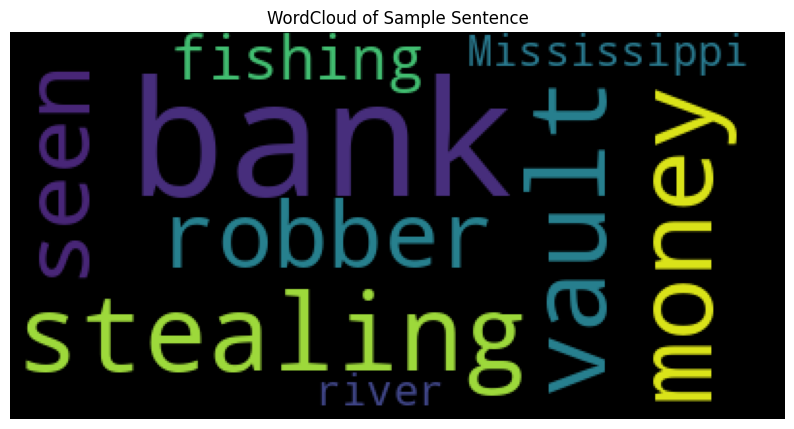

In [35]:
# plot word count for news text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(text)
fig = plt.figure(figsize=[10,10])
plt.title('WordCloud of Sample Sentence')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [36]:
#Word2Vec
#training the gensim on the data
#Using the Cbow architecture for the word2Vec
#, size = 50 removed from word2Vec
from gensim.models import Word2Vec 
model_cbow = Word2Vec([text.split(" ")], min_count = 1, workers = 3, vector_size = 50, window = 5, sg = 0)

In [37]:
model_cbow.init_sims(replace = True)
model_cbow.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [38]:
words = list(model_cbow.wv.index_to_key)
print(words)


['bank', 'the', 'river', 'Mississippi', 'on', 'fishing', 'seen', 'was', 'robber', 'vault', 'from', 'money', 'stealing', 'After']


In [39]:
vector = model_cbow.wv['bank'] 
vector

array([-0.01259352,  0.00555269,  0.11985431,  0.21158655, -0.21848367,
       -0.16714124,  0.15168934,  0.2107344 , -0.11778943, -0.08838436,
        0.17333424, -0.03601422, -0.10654427,  0.15392466, -0.1141429 ,
       -0.04264994,  0.06755769,  0.02329457, -0.19458175, -0.22190945,
        0.1717199 ,  0.11907724,  0.15870726,  0.01791622,  0.14915332,
       -0.07997645, -0.02222663,  0.13547736, -0.17664881, -0.09244104,
       -0.17641266, -0.02184243,  0.22400671, -0.1718937 , -0.05480954,
       -0.04550866,  0.189702  , -0.13928957,  0.00106066, -0.11164343,
       -0.22554341,  0.11759838, -0.20572253, -0.10314386, -0.00082434,
       -0.00695595, -0.17992744,  0.22580628,  0.11700572,  0.21684425],
      dtype=float32)

In [40]:
print('the array representation of the word \'bank\'\n:',model_cbow.wv['bank'], '\n the array representation of the word \'robber\'\n:', model_cbow.wv['robber']) 

the array representation of the word 'bank'
: [-0.01259352  0.00555269  0.11985431  0.21158655 -0.21848367 -0.16714124
  0.15168934  0.2107344  -0.11778943 -0.08838436  0.17333424 -0.03601422
 -0.10654427  0.15392466 -0.1141429  -0.04264994  0.06755769  0.02329457
 -0.19458175 -0.22190945  0.1717199   0.11907724  0.15870726  0.01791622
  0.14915332 -0.07997645 -0.02222663  0.13547736 -0.17664881 -0.09244104
 -0.17641266 -0.02184243  0.22400671 -0.1718937  -0.05480954 -0.04550866
  0.189702   -0.13928957  0.00106066 -0.11164343 -0.22554341  0.11759838
 -0.20572253 -0.10314386 -0.00082434 -0.00695595 -0.17992744  0.22580628
  0.11700572  0.21684425] 
 the array representation of the word 'robber'
: [-0.18355328  0.03191495 -0.18450207 -0.05770317  0.09562866  0.14996925
  0.03079692  0.05406347 -0.10566583  0.18576439 -0.16216265  0.11947794
 -0.21133634  0.05234125 -0.12794407 -0.10921183 -0.07994997  0.14537773
  0.14907673 -0.12788668  0.019877   -0.21842225  0.20076823  0.2379963
 -0

In [41]:
print(model_cbow.wv.most_similar('bank', 'vault'))

[('robber', 0.15167683362960815), ('river', 0.12220965325832367), ('was', 0.09942746162414551), ('stealing', 0.08457799255847931), ('money', 0.08098877966403961), ('Mississippi', 0.08072850108146667), ('from', 0.07423313707113266), ('the', 0.030568802729249), ('After', 0.01814216934144497), ('on', -0.04082303121685982)]


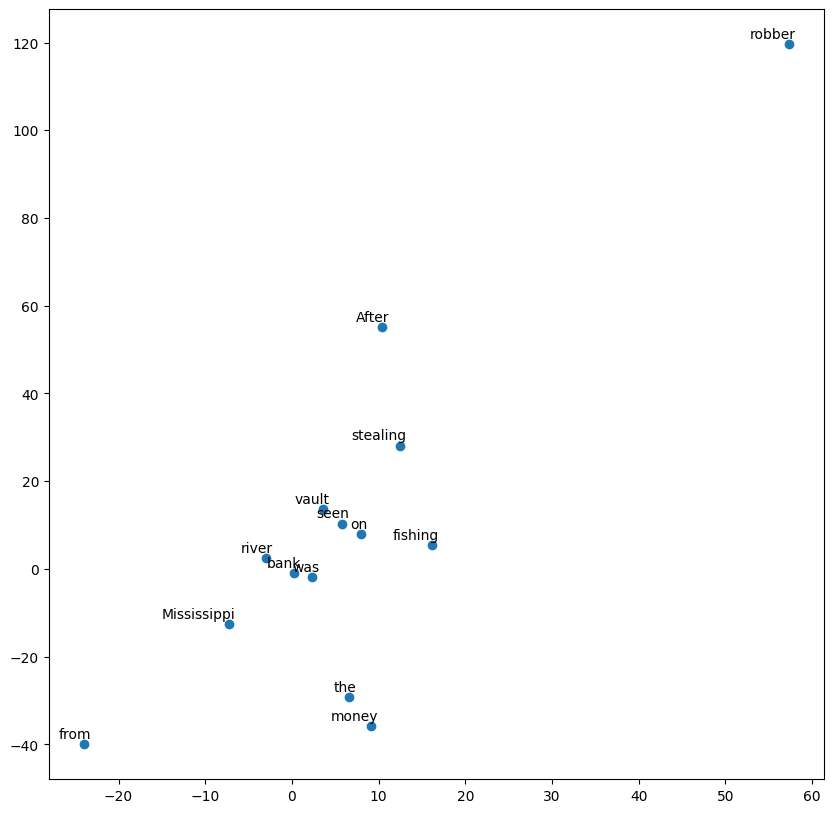

In [42]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def plot_tsne(model, num):
    labels = model.wv.index_to_key[:num]
    tokens = model.wv[model.wv.index_to_key[:num]]

    tsne = TSNE(perplexity=4, n_components=2, init='pca', n_iter=250, random_state=42)
    data = tsne.fit_transform(tokens)

    x = data[:, 0]
    y = data[:, 1]

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y)

    for i, label in enumerate(labels):
        plt.annotate(label, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.show()

# Usage example
plot_tsne(model_cbow, 300)

# Word2Vec Skip Gram

In [43]:
model_skipgram = Word2Vec([text.split(" ")], min_count = 1, vector_size = 50, workers = 3, window = 5, sg = 1)

In [44]:
model_skipgram.init_sims(replace = True)
model_skipgram.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [45]:
words = list(model_skipgram.wv.index_to_key)
print(words)

['bank', 'the', 'river', 'Mississippi', 'on', 'fishing', 'seen', 'was', 'robber', 'vault', 'from', 'money', 'stealing', 'After']


In [46]:
vector = model_skipgram.wv['bank'] 
vector

array([-0.01259352,  0.00555269,  0.11985431,  0.21158655, -0.21848367,
       -0.16714124,  0.15168934,  0.2107344 , -0.11778943, -0.08838436,
        0.17333424, -0.03601422, -0.10654427,  0.15392466, -0.1141429 ,
       -0.04264994,  0.06755769,  0.02329457, -0.19458175, -0.22190945,
        0.1717199 ,  0.11907724,  0.15870726,  0.01791622,  0.14915332,
       -0.07997645, -0.02222663,  0.13547736, -0.17664881, -0.09244104,
       -0.17641266, -0.02184243,  0.22400671, -0.1718937 , -0.05480954,
       -0.04550866,  0.189702  , -0.13928957,  0.00106066, -0.11164343,
       -0.22554341,  0.11759838, -0.20572253, -0.10314386, -0.00082434,
       -0.00695595, -0.17992744,  0.22580628,  0.11700572,  0.21684425],
      dtype=float32)

In [47]:
print(model_skipgram.wv.most_similar('river', 'bank'))

[('on', 0.21477800607681274), ('robber', 0.1479063332080841), ('seen', 0.11235106736421585), ('from', 0.1012321263551712), ('money', -0.008977381512522697), ('the', -0.023684391751885414), ('fishing', -0.030451636761426926), ('stealing', -0.056015897542238235), ('After', -0.09814958274364471), ('vault', -0.10375411063432693)]


In [48]:
print('the array representation of the word \'river\'\n:',model_cbow.wv['river'], '\n the array representation of the word \'bank\'\n:', model_cbow.wv['bank']) 

the array representation of the word 'river'
: [-0.20642233  0.08778626  0.12428615  0.13750665  0.17881607 -0.1477021
  0.02647698  0.14481895 -0.06801289 -0.14784212 -0.00982393 -0.20041768
 -0.13410783  0.17013788  0.08028586  0.17303869  0.16285078  0.1803445
 -0.09074181 -0.013454    0.05623839 -0.10822076  0.20089145 -0.23608108
  0.1619981   0.0697938  -0.11813033  0.1053268  -0.04165894  0.16072272
  0.23863597 -0.10447081 -0.01435281 -0.13639784  0.09221862  0.06673351
  0.16502593  0.14610766  0.22842576  0.2220777   0.18914114 -0.16738306
 -0.21926259 -0.00851949 -0.07423428  0.18905132  0.14221562 -0.03701518
  0.03618421  0.04286749] 
 the array representation of the word 'bank'
: [-0.01259352  0.00555269  0.11985431  0.21158655 -0.21848367 -0.16714124
  0.15168934  0.2107344  -0.11778943 -0.08838436  0.17333424 -0.03601422
 -0.10654427  0.15392466 -0.1141429  -0.04264994  0.06755769  0.02329457
 -0.19458175 -0.22190945  0.1717199   0.11907724  0.15870726  0.01791622
  0.1

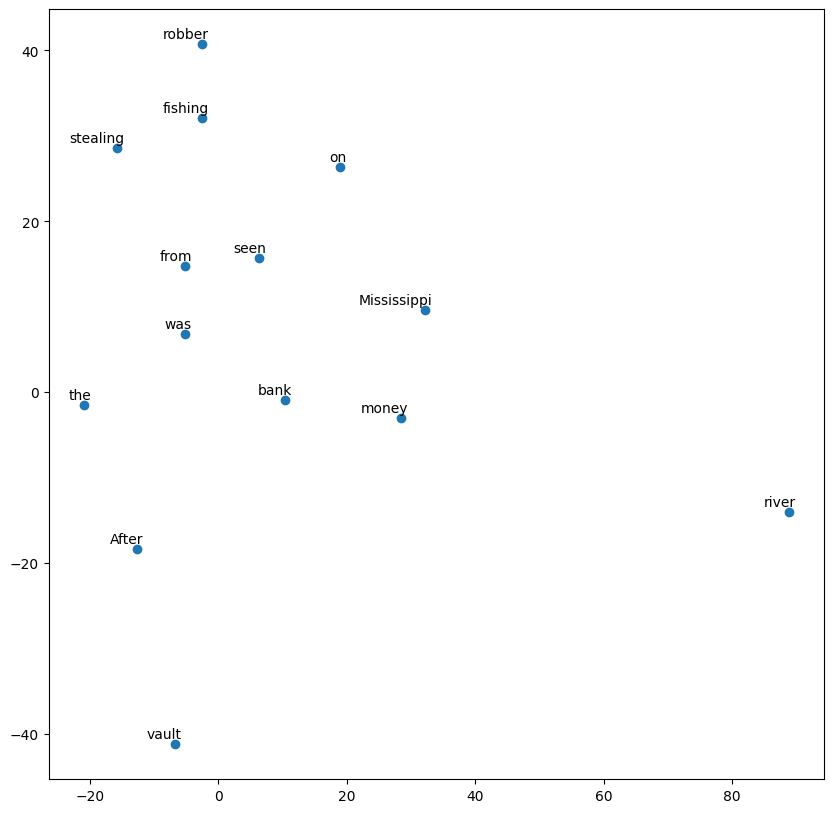

In [49]:
plot_tsne(model_skipgram,100)

# Word2vec has two options and belows in the comparision/understanding after generating embeddings and topic modeling

| Continuous Bag of Words  | skip-gram |
| ------ | ------ |
| The CBOW architecture, as the name suggests, predicts the target word based on the context words surrounding it. It takes a window of context words as input and tries to maximize the probability of predicting the target word. Here are some characteristics of the CBOW model | The Skip-gram architecture aims to predict the context words given a target word. It takes a target word as input and tries to maximize the probability of predicting the surrounding context words. Here are some characteristics of the Skip-gram model |
|Eg: In this sentence  "After stealing money from the bank vault the bank robber was seen fishing on the Mississippi river bank" <span style="background-color: #FFFF00"> river, bank, Mississippi</span> appears closer with less distance to each other | Eg: In this sentence  "After stealing money from the bank vault the bank robber was seen fishing on the Mississippi river bank" <span style="background-color: #FFFF00"> robber, fishing, stealing</span> appears closer with less distance to each other |


#  ✅ BERT Vector Embeddings (With Prerained)

In [50]:
from pytorch_pretrained_bert import BertTokenizer
import sys
import numpy as np
import random as rn
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [52]:
tokenize_ = tokenizer.tokenize(text)
print("Text after tokenization: ")
print(tokenize_)
max_len = 25

textLst = tokenize_[:max_len-2]
input_sequence = ["[CLS]"] + textLst + ["[SEP]"]
pad_len = max_len - len(input_sequence)

print("After adding [CLS] and [SEP]: ")
print(input_sequence)
tokens = tokenizer.convert_tokens_to_ids(input_sequence)
print("After converting Tokens to Id: ")
print(tokens)
tokens += [0] * pad_len
print("tokens: ")
print(tokens)
pad_masks = [1] * len(input_sequence) + [0] * pad_len
print("Pad Masking: ")
print(pad_masks)
segment_ids = [0] * max_len
print("Segment Ids: ")
print(segment_ids)

Text after tokenization: 
['after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank']
After adding [CLS] and [SEP]: 
['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '[SEP]']
After converting Tokens to Id: 
[101, 2044, 11065, 2769, 2013, 1996, 2924, 11632, 1996, 2924, 27307, 2001, 2464, 5645, 2006, 1996, 5900, 2314, 2924, 102]
tokens: 
[101, 2044, 11065, 2769, 2013, 1996, 2924, 11632, 1996, 2924, 27307, 2001, 2464, 5645, 2006, 1996, 5900, 2314, 2924, 102, 0, 0, 0, 0, 0]
Pad Masking: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Segment Ids: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
segments_ids = [1] * len(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Print out the tokens.
print (tokenized_text)


['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '[SEP]']


In [54]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Li

In [55]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([20, 12, 768])

In [56]:
# Stores the token vectors, with shape [23 x 768]
token_vecs_sum = []

# `token_embeddings` is a [23 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 20 x 768


In [57]:
# Stores the token vectors, with shape [23 x 768]
token_vecs_sum = []

# `token_embeddings` is a [23 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 20 x 768


In [58]:
# `encoded_layers` has shape [12 x 1 x 23 x 768]

# `token_vecs` is a tensor with shape [23 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 23 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [59]:
sentence_embedding[0]

tensor(0.1697)

# ✅ Comparison of word2vec(Continuous Bag of Words,skip-gram), BERT
We have choose these two techniques and BERT is the most efficient among all
- word2vec without pre trained model (Building Corpus on Your Own)
- BERT (pre trained model) . Reason for choosing BERT is BERT’s sensitivity to single-word cues in context, we draw on data from semantic priming observed in humans. BERT's ability to capture contextual meaning, bidirectional training, pretraining, fine-tuning, and task-agnostic nature make it a more powerful and flexible model compared to GloVe. However, it's worth noting that GloVe still has its merits and can be useful in certain scenarios where contextual information may not be crucial or where computational resources are limited.
- Advantage of using pre trained model is save time, resources, and money compared to building and training your own model. And they are often as effective and more efficient than custom models

| WordVec  | Glove |  BERT |
| ------ | ------ | ------ |
|Performs well on syntactic and semantic analogies and generate efficient and simple word embeddings.Predictive Model| Generates static word embeddings | Captures contextual word representations and bidirectional training for deeper word understanding|
| Pretrained models (corpus) available |Pretrained models (corpus) available | Pretraining and fine-tuning framework |
| Requires substantial computational resources |Requires substantial computational resources | Requires more computational resources.|
| Limited understanding of word relationships and dependencies. |Ignores contextual information. | BERT models look at the surrounding words to understand the context.|



# ✅ Discussion on the embeddings that provide better semantic understanding (BERT has better Understanding)

| Aspect  | BERT |  Word2Vec |
| ------ | ------ | ------ |
| Model Type | Contextualized word embeddings | Static word embeddings |
| Semantic | Captures contextualized meaning, considering surrounding context | Captures distributional patterns and linear semantic relations |
| Understanding | Considers entire surrounding context | Focuses on local context within a fixed window |
| Context | Performs well on various NLP tasks, including semantic tasks | Focuses on local context within a fixed window |
| Task Performance | Provides fine-grained understanding of word meaning | Effective for tasks involving semantic associations and analogies |
| Granularity | Provides fine-grained understanding of word meaning | Captures broader semantic associations  |
| Pre-training Time | Requires significant pre-training time | Faster pre-training compared to BERT |
| Fine-tuning | Allows fine-tuning on specific downstream tasks | Limited fine-tuning capabilities |


# ✅ Part 2: Text Classification Model 
   - Correct implementation of chosen classification model
   - Comprehensive discussion on the choice of model, including its advantages and disadvantages

## Steps Done below are

Classifcation algorithm : MultinomialNB
Best Set of Hyperparams identified by RandomizedSearchCV
Metrics : Classification report, Confusion Matrix and then ROC Curve

## Correct implementation of chosen classification model
 

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

# ✅ Hyperparameters 

In [61]:
import numpy as np

parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}


In [62]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [63]:
from time import time

t0 = time()
X_train = random_search.fit(data_train.data, data_train.target)
print(f"Done in {time() - t0:.3f}s")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Done in 155.060s


# ✅ Best Estimator

In [64]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 0.001
vect__max_df: 0.8
vect__min_df: 3
vect__ngram_range: (1, 2)
vect__norm: l2


In [65]:
random_search.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))])

In [66]:
preds = random_search.best_estimator_.predict(data_test.data)

y_train = data_train.target
y_test = data_test.target

In [67]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report


In [68]:
print(classification_report(data_test.target, preds))

              precision    recall  f1-score   support

           0       0.64      0.49      0.56       319
           1       0.88      0.85      0.87       389
           2       0.87      0.77      0.81       396
           3       0.80      0.83      0.82       394
           4       0.55      0.84      0.67       398
           5       0.50      0.31      0.38       251

    accuracy                           0.71      2147
   macro avg       0.71      0.68      0.68      2147
weighted avg       0.72      0.71      0.71      2147



In [69]:
from sklearn import metrics

 

classification_report = metrics.classification_report(data_test.target, 
                                                      preds,
                                                      target_names=data_test.target_names)
print(classification_report)

 

# Access precision and recall scores
scores = metrics.precision_recall_fscore_support(data_test.target, preds)
precision = scores[0]
recall = scores[1]

 

print("Precision:", precision)
print("Recall:", recall)

                        precision    recall  f1-score   support

           alt.atheism       0.64      0.49      0.56       319
         comp.graphics       0.88      0.85      0.87       389
               sci.med       0.87      0.77      0.81       396
             sci.space       0.80      0.83      0.82       394
soc.religion.christian       0.55      0.84      0.67       398
    talk.religion.misc       0.50      0.31      0.38       251

              accuracy                           0.71      2147
             macro avg       0.71      0.68      0.68      2147
          weighted avg       0.72      0.71      0.71      2147

Precision: [0.64344262 0.87830688 0.86609687 0.80392157 0.55172414 0.49681529]
Recall: [0.49216301 0.85347044 0.76767677 0.83248731 0.84422111 0.31075697]


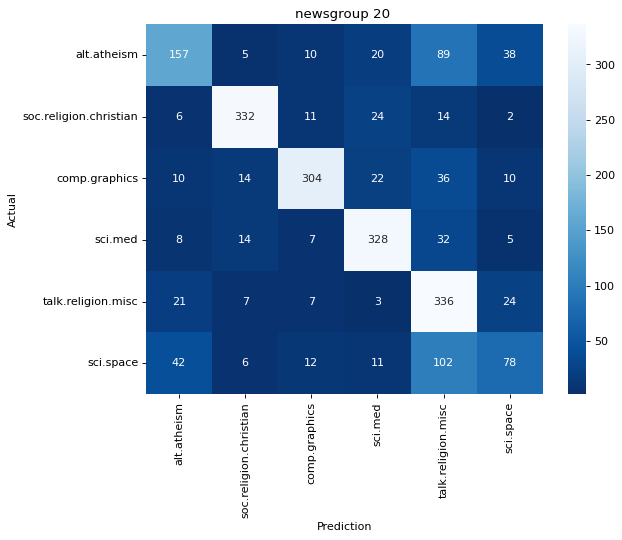

In [70]:
pred_ls = preds
test_ls = data_test.target

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

CLASSES = categories
ax = sns.heatmap(conf_arr, cmap="Blues_r", annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('newsgroup 20 ')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show(ax)

In [71]:
x_validation,y_validation =convert_to_np(data_test)
x_train,y_train = convert_to_np(data_train)


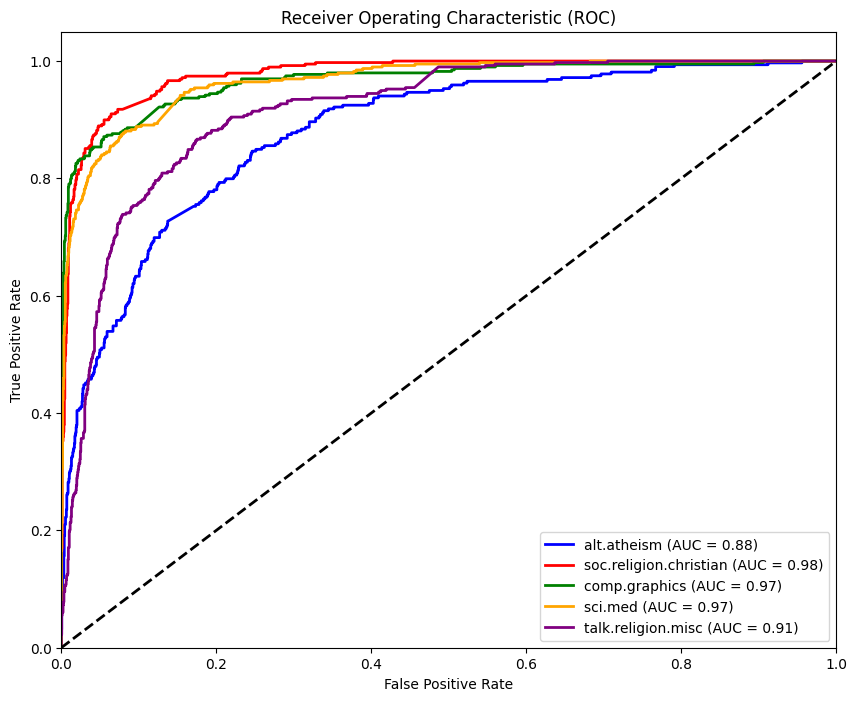

In [72]:

#startt
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

X_train = x_train
X_test=x_validation
y_test=y_validation
# Split the dataset into training and testing sets

# Convert the text data into TF-IDF features
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#Train a MultinomialNB classifier
classifier =  MultinomialNB()
classifier.fit(X_train, y_train)

# Predict probabilities for the test set
y_scores =  classifier.predict_proba(X_test)

# Binarize the true labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=categories[i]+' (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

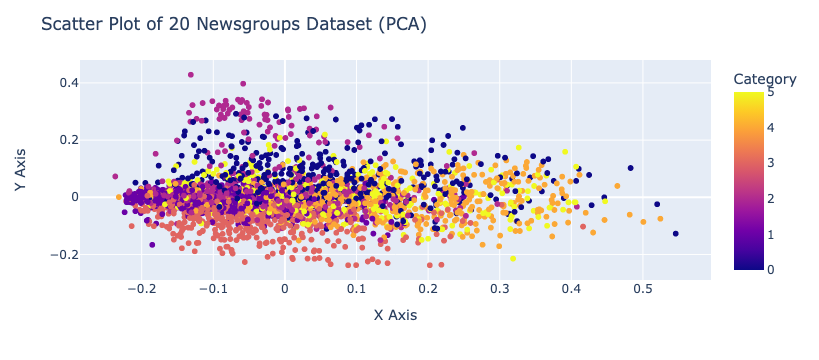

In [153]:
import plotly.express as px
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data.data)
y = data.target


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=y, labels={'color': 'Category'})
fig.update_layout(title='Scatter Plot of 20 Newsgroups Dataset (PCA)',
                  xaxis_title='X Axis',
                  yaxis_title='Y Axis')
fig.show()


# Comprehensive discussion on the choice of model, including its advantages and disadvantages

Word embeddings are generated by TF-IDF
We used Naive Bayes Classifier and it is a good choice for  Multi-class Prediction. Here we can predict the probability of multiple classes of target variable. 


# Part 3: Text Clustering Model  
   - Correct implementation of chosen clustering model
   - Comprehensive discussion on the choice of model, including its pros and cons

# we choosen KNeighborsClassifier as clustering algorithm
Also incorporated K fold Cross Validation technique in it

In [74]:
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px

In [75]:
from __future__ import print_function

from sklearn import __version__ as sklearn_version
print('Sklearn version:', sklearn_version)
from sklearn import model_selection
from imblearn.under_sampling import RandomUnderSampler


Sklearn version: 1.2.2


In [76]:
from __future__ import print_function

from comet_ml import Experiment

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import numpy as np

kf = KFold(n_splits=10)
curr_fold = 0
acc_dict = {}

for train_idx, test_idx in kf.split(x_train):
    text_clf = Pipeline([('vect', CountVectorizer()),  # Counts occurrences of each word
                         ('tfidf', TfidfTransformer()),  # Normalize the counts based on document length
                         ('clf', KNeighborsClassifier(n_neighbors=3, weights='uniform')),
                         ])
    
    

    text_clf.fit(x_train[train_idx].tolist(), y_train[train_idx])

    # Predict unseen test data based on fitted classifer
    predicted = text_clf.predict(x_train[test_idx])

    # Compute accuracy
    acc = accuracy_score(y_train[test_idx].tolist(), predicted)
    acc_dict[curr_fold]=acc
    print("accuracy_fold_%s" % curr_fold, acc)

    curr_fold += 1

accuracy_fold_0 0.25077399380804954
accuracy_fold_1 0.28792569659442724
accuracy_fold_2 0.24458204334365324
accuracy_fold_3 0.30959752321981426
accuracy_fold_4 0.26625386996904027
accuracy_fold_5 0.2755417956656347
accuracy_fold_6 0.22910216718266255
accuracy_fold_7 0.2422360248447205
accuracy_fold_8 0.2453416149068323
accuracy_fold_9 0.2422360248447205


# <to revist>

In [77]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

pipe_knn = Pipeline([('vect', TfidfVectorizer(stop_words='english')),
                         ('lda', LDA(n_components=6, max_iter=25,
                                 learning_method='online',
                                 learning_offset=200.,
                                 random_state=0)),
                         ('clf',  KNeighborsClassifier()),
                        ])


# Fitting our train data to the pipeline
pipe_knn.fit(data_train.data, data_train.target)

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           learning_offset=200.0, max_iter=25,
                                           n_components=6, random_state=0)),
                ('clf', KNeighborsClassifier())])

In [78]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

param_range=[2,3]
knn_param_grid=[{
                'clf__n_neighbors': param_range,
                'clf__weights': ['uniform', 'distance'],
                'clf__metric': ['euclidean', 'manhattan']
                }]

random_search = RandomizedSearchCV(
    pipe_knn,
    param_distributions=knn_param_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(knn_param_grid)

Performing grid search...
Hyperparameters to be evaluated:
[{'clf__metric': ['euclidean', 'manhattan'],
  'clf__n_neighbors': [2, 3],
  'clf__weights': ['uniform', 'distance']}]


In [79]:
from time import time

t0 = time()
X_train = random_search.fit(data_test.data, data_test.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Done in 258.344s


In [80]:
# Predicting our test data
predicted = random_search.best_estimator_.predict(data_test.data)
print('We got an accuracy of',np.mean(predicted == data_test.target)*100, '% over the test data.')

We got an accuracy of 97.5780158360503 % over the test data.


# Clustering : 2
BERTopic processes the documents, obtains BERT embeddings, reduces the dimensionality, performs clusterin
- <span style="background-color: #FFFF00">Step 1</span>: Preprocessing BERTopic preprocesses the input documents by performing text cleaning, tokenization, and encoding.
- <span style="background-color: #FFFF00">Step 2</span>: BERT Embeddings BERTopic uses a pre-trained BERT model to obtain contextualized embeddings for each document.
- <span style="background-color: #FFFF00">Step 3</span>: Dimensionality Reduction BERTopic applies UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of the document embeddings while preserving the local structure of the data.
- <span style="background-color: #FFFF00">Step 4</span>: Clustering BERTopic applies the HDBSCAN algorithm to cluster the reduced embeddings
- <span style="background-color: #FFFF00">Step 5</span>: Topic Assignment BERTopic assigns a topic label to each document based on the cluster it belongs to.Probability Calculation The probabilities of topic assignments are calculated based on the distances between the document embeddings and the centroid of each topic cluster.The probabilities are normalized so that they sum up to 1 across all topics.

In [81]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)



2023-07-09 20:09:40.851464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Batches:   0%|          | 0/101 [00:00<?, ?it/s]

2023-07-09 20:13:16,800 - BERTopic - Transformed documents to Embeddings
2023-07-09 20:13:40,577 - BERTopic - Reduced dimensionality
2023-07-09 20:13:41,449 - BERTopic - Clustered reduced embeddings


In [99]:
bert_data_train  = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
bert_data_test  = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

In [101]:
topics, probs = topic_model.fit_transform(bert_data_train.data)

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

2023-07-09 20:23:29,422 - BERTopic - Transformed documents to Embeddings
2023-07-09 20:23:45,979 - BERTopic - Reduced dimensionality
2023-07-09 20:23:46,558 - BERTopic - Clustered reduced embeddings
2023-07-09 20:23:47,882 - BERTopic - Reduced number of topics from 40 to 40


In [102]:
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,644,-1_the_of_to_that,"[the, of, to, that, and, is, in, it, not, you]","[\n[..]\n\n\nHello. Firstly, what do you exac..."
1,0,27,0____,"[, , , , , , , , , ]","[, , ]"
2,1,58,1_hello___,"[hello, , , , , , , , , ]","[, Hello,, Hello,]"
3,2,494,2_the_of_and_to,"[the, of, and, to, in, is, it, that, with, my]","[\n\nIf people are going to do this, I really ..."
4,3,14,3_photography_kirlian_pictures_object,"[photography, kirlian, pictures, object, field...",[I think that's the correct spelling..\n\tI am...
5,4,535,4_image_for_and_the,"[image, for, and, the, to, is, on, of, it, you]",[Archive-name: typing-injury-faq/software\nVer...
6,5,22,5_marriage_married_ceremony_to,"[marriage, married, ceremony, to, have, couple...",[\n\tI originally wrote to the person who aske...
7,6,15,6_42_question_answer_alice,"[42, question, answer, alice, discovered, ever...","[: Well,\n: \n: 42 is 101010 binary, and who w..."
8,7,595,7_the_space_and_to,"[the, space, and, to, of, for, in, on, is, be]",[I've been to three talks in the last month wh...
9,8,20,8_easter_pagan_the_resurrection,"[easter, pagan, the, resurrection, of, is, tha...","[for SRC\n\nIn most languages, the Feast of th..."


In [103]:
freq['Name'].head()

0                        -1_the_of_to_that
1                                    0____
2                               1_hello___
3                          2_the_of_and_to
4    3_photography_kirlian_pictures_object
Name: Name, dtype: object

In [104]:
freq['Representation'].head()

0       [the, of, to, that, and, is, in, it, not, you]
1                                 [, , , , , , , , , ]
2                            [hello, , , , , , , , , ]
3       [the, of, and, to, in, is, it, that, with, my]
4    [photography, kirlian, pictures, object, field...
Name: Representation, dtype: object

In [105]:
freq['Representative_Docs'].head()

0    [\n[..]\n\n\nHello.  Firstly, what do you exac...
1                                               [, , ]
2                                   [, Hello,, Hello,]
3    [\n\nIf people are going to do this, I really ...
4    [I think that's the correct spelling..\n\tI am...
Name: Representative_Docs, dtype: object

In [106]:
topic_model.get_topic(0)  # Selecting the most frequent topic

[('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

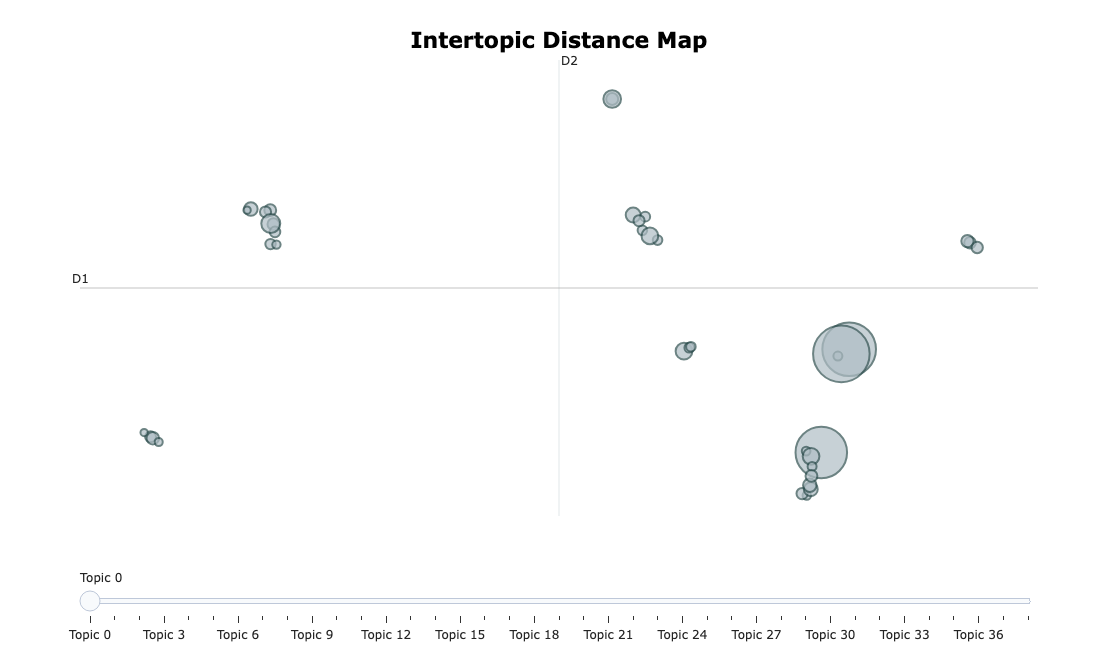

In [107]:
topic_model.visualize_topics()

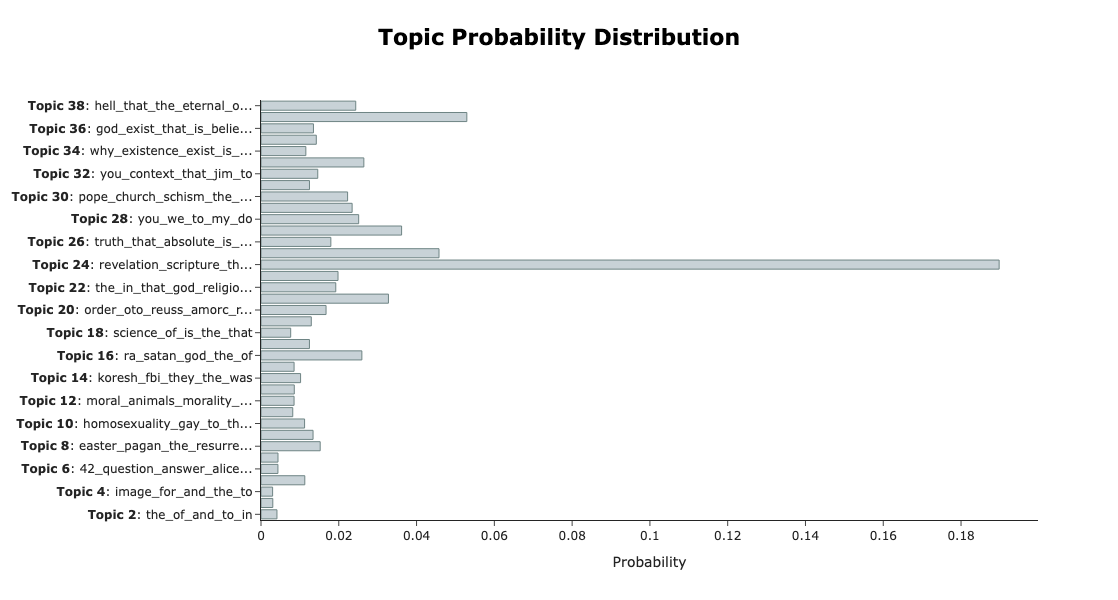

In [108]:
topic_model.visualize_distribution(probs[1], min_probability=0.001)

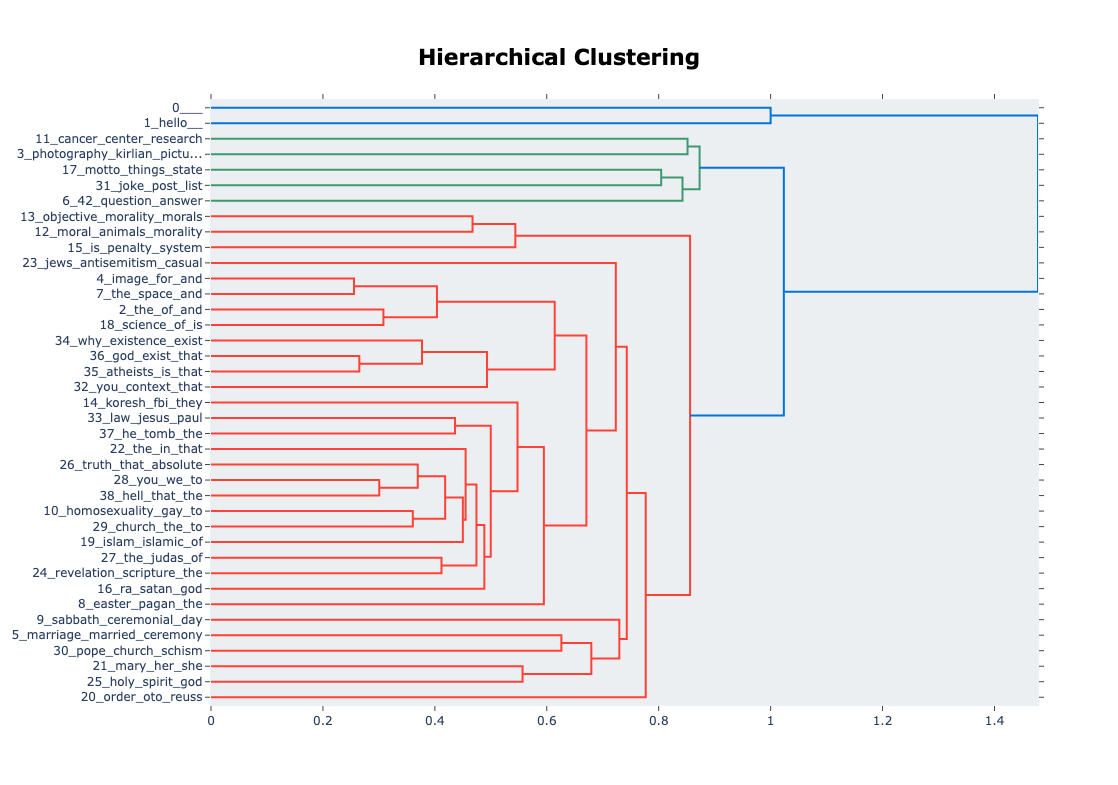

In [109]:
topic_model.visualize_hierarchy(top_n_topics=50)

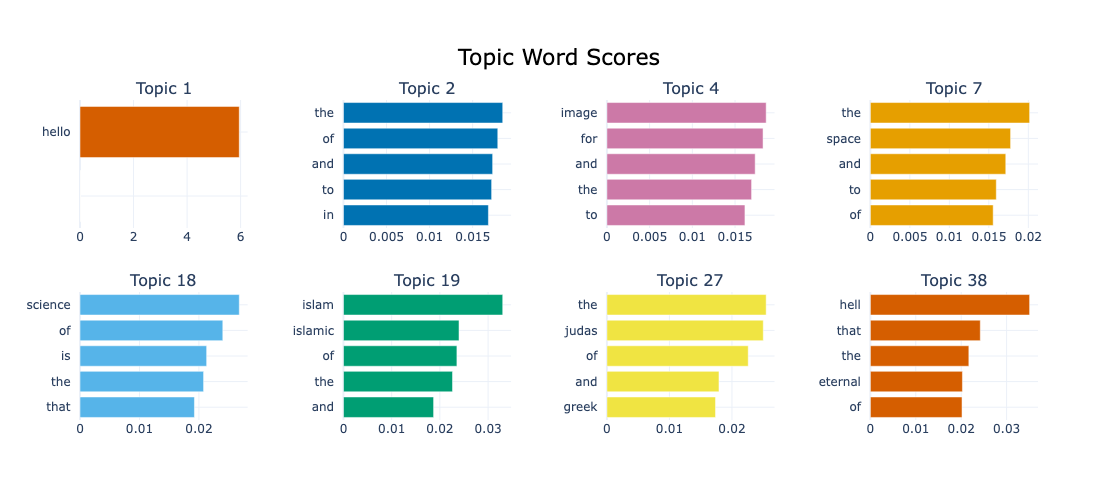

In [110]:
topic_model.visualize_barchart(top_n_topics=8)

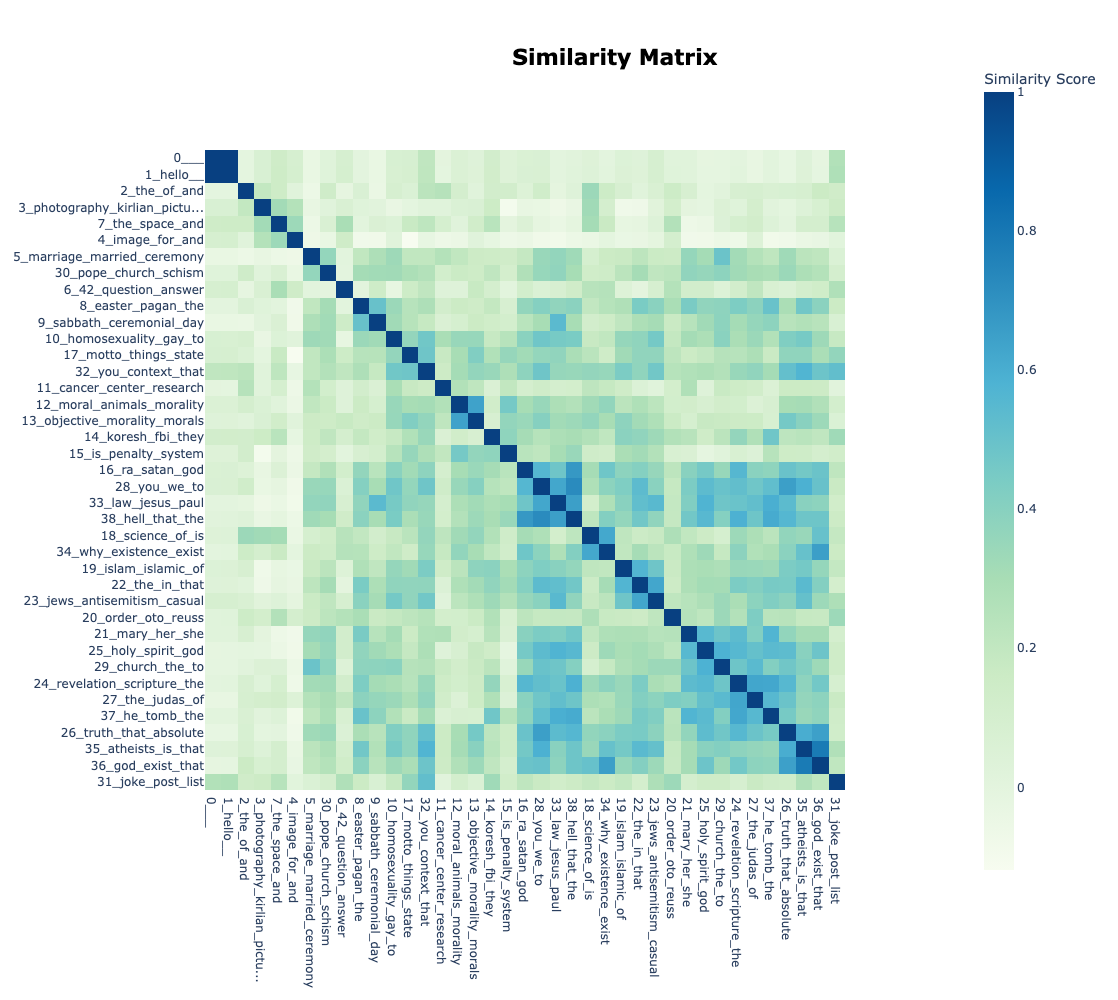

In [111]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

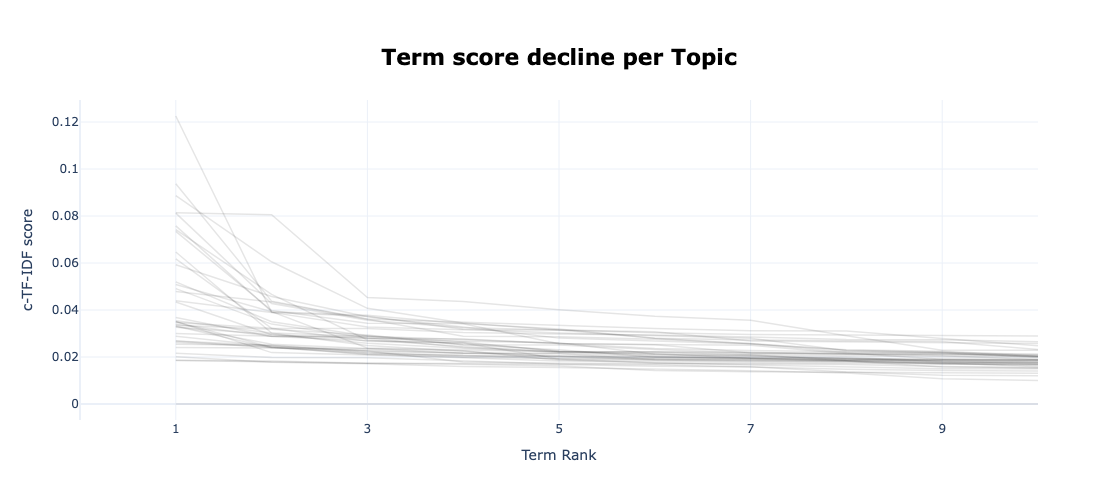

In [112]:
topic_model.visualize_term_rank()

In [122]:
topic_model.reduce_topics(bert_data_train.data, nr_topics=20)

2023-07-09 20:25:58,194 - BERTopic - Reduced number of topics from 40 to 20


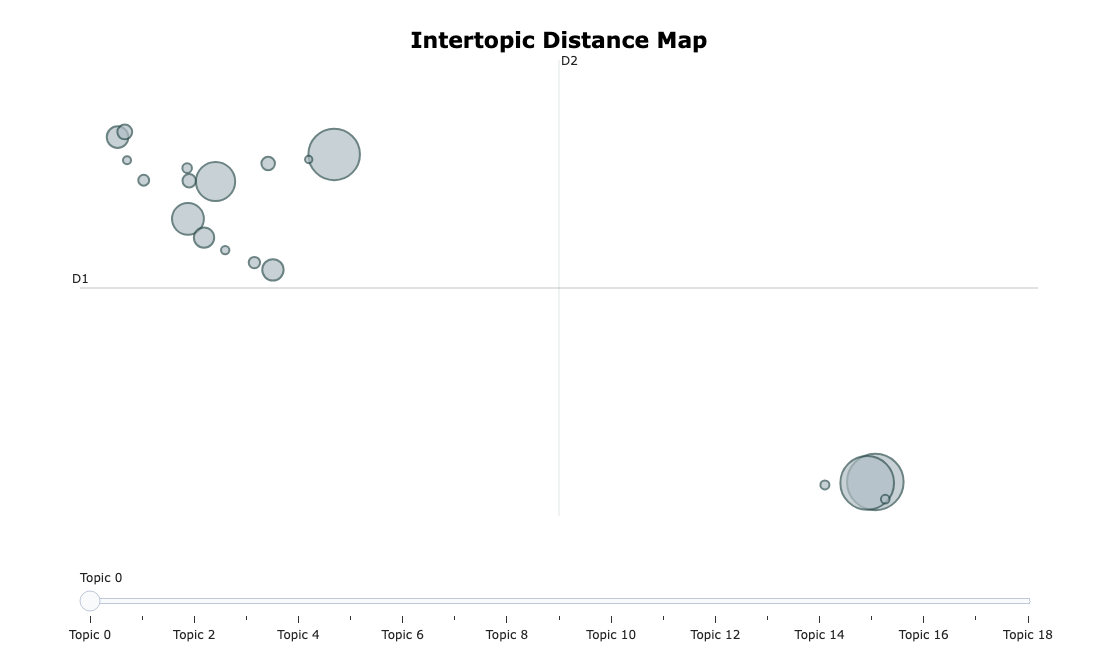

In [123]:
topic_model.visualize_topics()

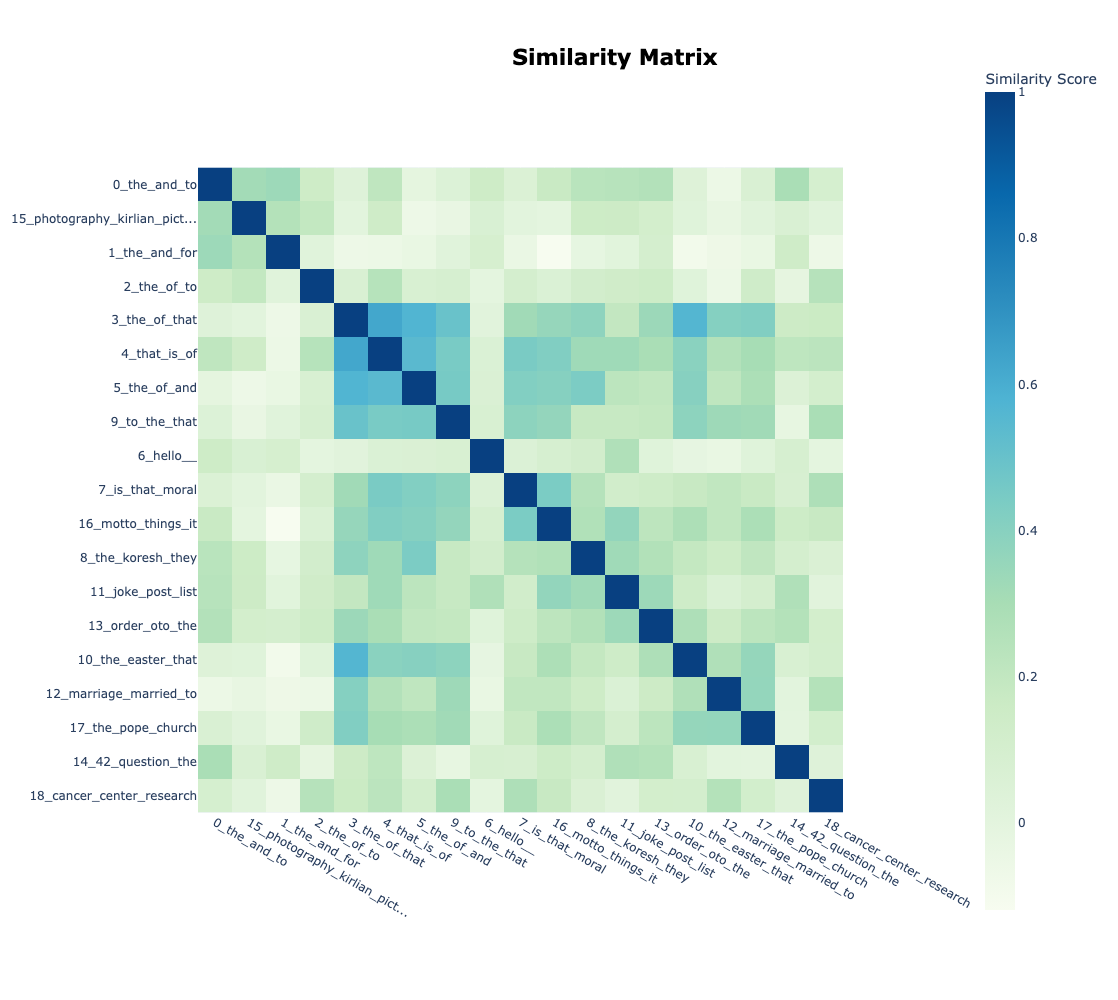

In [136]:
topic_model.visualize_heatmap(n_clusters=10, width=1000, height=1000)

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



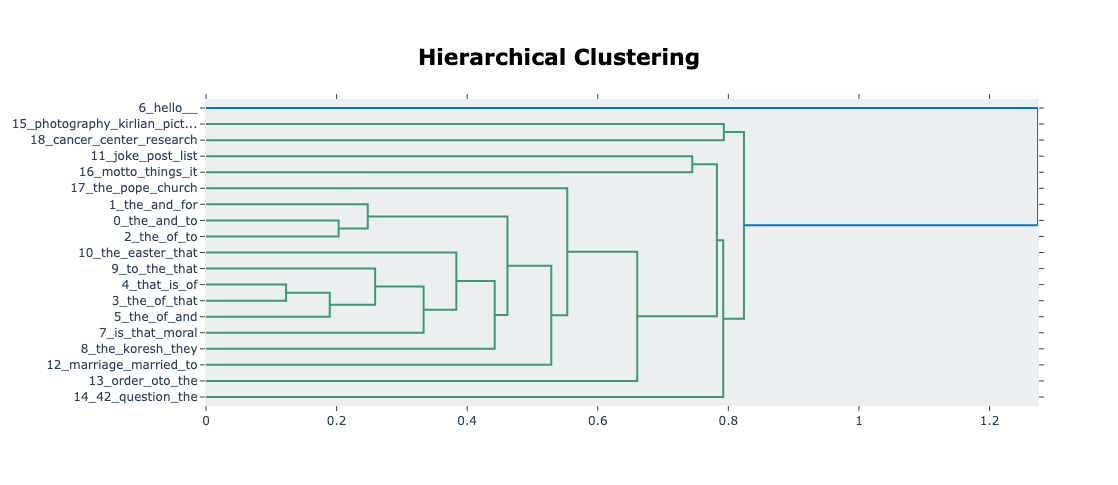

In [137]:
topic_model.visualize_hierarchy(top_n_topics=50)

# Introduce imbalance And see the clustering

In [138]:
newsgroups_train = fetch_20newsgroups(subset="train", categories=categories)
newsgroups_test = fetch_20newsgroups(subset="test", categories=categories)

X_train = data_train.data
X_test = data_test.data

y_train = data_train.target
y_test = data_test.target

In [139]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Few ways we tried handle to Imbalance 
- smote = SMOTE() ==> X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
- RandomUnderSampler


# Dealing with abbreviation and misspelled words 

Dataframe contains misspelled words and abbreviations like the below will be corrected using Spellchecker

In [141]:
import pandas as pd
from spellchecker import SpellChecker

In [142]:
df = pd.DataFrame(['swtch', 'cola', 'FBI', 'smsng', 'BCA', 'MIB'], columns=['misspelled'])
abbreviations = {
    'FBI': 'Federal Bureau of Investigation',
    'BCA': 'Bank Central Asia',
    'MIB': 'Men In Black',
    'cola': 'Coca Cola'
}

spell = SpellChecker()
df['fixed'] = df['misspelled'].apply(spell.correction).replace(abbreviations)
print("Misspelled and short form been corrected and abbreviated")
print(df)

Misspelled and short form been corrected and abbreviated
  misspelled                            fixed
0      swtch                           switch
1       cola                        Coca Cola
2        FBI  Federal Bureau of Investigation
3      smsng                             sing
4        BCA                              bra
5        MIB                              mix


# Word Sense Disambiguation

When means two or more words with the same spelling may have different meanings in different contexts. This often leads to ambiguity. Word sense disambiguation is the process of mapping a word to the sense that it should carry. We need to disambiguate words based on the sense they carry so that they can be treated as different entities when being analyzed.

In [143]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.wsd import lesk
from nltk import word_tokenize

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We took 'Bank' as example to diffentiate
sentence1: "Keep your savings in the bank"
sentence2: "It's so risky to drive over the banks of the road"

In [144]:
sentence1 = "Keep your savings in the bank"
sentence2 = "It's so risky to drive over the banks of the road"

Sentence 1

In [145]:
def get_synset(sentence, word):
    return lesk(word_tokenize(sentence), word)
get_synset(sentence1,'bank')

Synset('savings_bank.n.02')

Here, savings_bank.n.02 refers to a container for keeping money safely at home

In [146]:
get_synset(sentence2,'bank')

Synset('bank.v.07')

Here, bank.v.07 refers to a slope in the turn of a road.

Thus, with the help of the Lesk algorithm, we were able to identify the sense of a word in whatever context.


# Dealing with Slang


we go for the SMS slangs that is changing “bt” to “but”, “hv” to “have”, “nt” to “not”. But making them manually is not possible because there are so many of them. using dictionary words and words downloaded from online we make our input in much elaborated format

Create Dictionary words

In [148]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
    
    
}

Create a request for the web page and give us the HTML page from which we will extract the keyword. “alpha” will be [a-z] as the links in the webpage are as follows

For all slangs starting with ‘A’: https://www.noslang.com/dictionary/a

For all slangs starting with ‘B’: https://www.noslang.com/dictionary/b

Create and Write it into file in JSON format

In [134]:
from bs4 import BeautifulSoup
import urllib3
import json
http=urllib3.PoolManager()
Abbr_dict={}
#Function to get the Slangs from https://www.noslang.com/dictionary/
def getAbbr(alpha):
    global Abbr_dict
    r=http.request('GET','https://www.noslang.com/dictionary/'+alpha)
    soup=BeautifulSoup(r.data,'html.parser')
   # print(soup.findAll('div'))
    for i in soup.findAll('div', class_="dictonary-word"): 
        abbr=i.find('abbr')['title']
        #print(abbr)
        Abbr_dict[str(i.text[:2])]=abbr
        #Abbr_dict[str(i.text)]=abbr[:2]
        #print(Abbr_dict)
        

linkDict=[]
#Generating a-z
for one in range(97,123):
    linkDict.append(chr(one))
#Creating Links for https://www.noslang.com/dictionary/a...https://www.noslang.com/dictionary/b....etc
for i in linkDict:
    getAbbr(i)
# finally writing into a json file
with open("ShortendText.json","w") as file:
    jsonDict = json.dump(Abbr_dict,file)
    print("File Created and Content added")

File Created and Content added


Based on our text and information it will fetch the corresponding slang in dictory and file and produce the result

In [135]:
import json

with open('ShortendText.json','r') as file:
    Abbr_dict=json.loads(file.read())
    
#print(Abbr_dict)
line = "can't've you, i'm always stuck and Ay . DG ."
print("Input: ",line)
splitLine=line.split()
#print("SplitLine1", splitLine)

for i in line.split():
    if i in CONTRACTION_MAP:
        #print(i,CONTRACTION_MAP[i])
        splitLine[splitLine.index(i)]=CONTRACTION_MAP[i]
        #print("SplitLine2", splitLine)
    if i in Abbr_dict :
        #print(i,Abbr_dict[i])
        splitLine[splitLine.index(i)]=Abbr_dict[i]
        #print("SplitLine3", splitLine)
        
result = ' '.join(splitLine)
print("Result:",result)

Input:  can't've you, i'm always stuck and Ay . DG .
Result: cannot have you, i am always stuck and Are you bored because I am . Don't get me wrong .
